In [ ]:
# 1. Imports
import torch, torchvision, os, PIL, pdb
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import gdown, zipfile
from math import ceil

Hyperparameters Setting

In [ ]:
# 2. Helper functions

def getDevice():
  if torch.cuda.is_available():
    device = 'cuda'
  else:
    device = 'cpu'
  return device

def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

def show(tensor, num):
  data = tensor.detach().cpu()
  #grid = make_grid(denorm(data[:num]), nrow=4).permute(1,2,0)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid) #.clip(0,1)
  plt.show()

In [ ]:
device = getDevice()
noise_dim = 128
#label_dim = 2
batch_size = 256
img_size = 64
img_dim = (img_size, img_size)
img_ch = 1 # greyscale
#lr = 1e-4
epochs = 100
save_step = 900
#embed_size = 100


# Hyperparameters
lr = 0.00025

stats = (0.1307,), (0.3081,)

Helper functions & misc

Dataset download and initialization

In [ ]:
# 1. Dataset Class
class MyDataset(Dataset):
  def __init__(self,remove_list, transform = None, train=True):
    self.mnist = datasets.MNIST(root='./data',
                                download=True,
                                train=train,
                                transform=transform)
    self.data = self.mnist.data
    self.targets = self.mnist.targets
    self.transform = transform
    mask = np.ones(len(self.data), dtype=bool)
    mask[remove_list] = False

    self.data = self.data[mask]
    self.targets = self.targets[mask]

  def __getitem__(self, index):
    data, target = self.data[index], self.targets[index]
    data = self.transform(np.array(data))
    return data, target

  def __len__(self):
    return len(self.data)

In [ ]:
mean_gray = 0.1307
stdd_gray = 0.3081

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([img_size, img_size]),
    #transforms.Normalize((mean_gray,),(stdd_gray,))
])

train_dataset = datasets.MNIST(
    root = 'data',
    download = True,
    train = True,
    transform = transformation
)

test_dataset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transformation
)

100%|██████████| 9912422/9912422 [00:00<00:00, 291428069.45it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115919324.23it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 180256246.16it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22229321.78it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# remove from mnist all non fives
rem_idx_one = ((train_dataset.targets != 5).nonzero(as_tuple=True)[0])
print(rem_idx_one.shape)

#### USe Only when data augmenting
transformation3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.85, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.Resize([img_size, img_size]),
])

traindat_fives = MyDataset(rem_idx_one, transformation3, True)
print(len(traindat_fives))

# create reduced subset

remove_idx = ((traindat_fives.targets == 5).nonzero(as_tuple=True)[0])
num = remove_idx.shape[0]
num = ceil(0.99 * num)
print(f'num {num}')

to_remove = remove_idx[:num]
to_keep = remove_idx[num:]
print(f'remove_idx.shape {to_keep.shape}')

trainset_1 = torch.utils.data.Subset(traindat_fives, to_keep)

torch.Size([54579])
5421
num 5367
remove_idx.shape torch.Size([54])


2
54


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


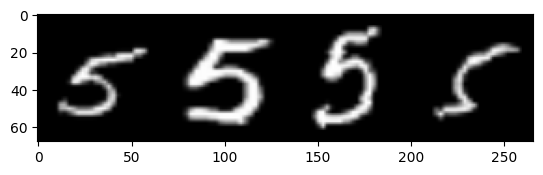

In [ ]:
# 4. Dataset Initialization
batch_size = 32

trainloader = DataLoader(
    #dataset = train_dataset,
    dataset = trainset_1,
    batch_size = batch_size,
    shuffle = True
)

print(len(trainloader))
print(len(trainset_1))
# dataset visualization
ha, labels = next(iter(trainloader))
show(ha, 4)

GAN declaration & architecture

In [ ]:
# a. Generator model

def genBlock(inp, out, f, s, p):
  return nn.Sequential(
      nn.ConvTranspose2d(inp, out, f, s, p),
      nn.BatchNorm2d(out),
      nn.ReLU(True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=noise_dim, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    #self.embed_size = embed_size
    #self.labels_dim = labels_dim
    #self.embed = nn.Embedding(labels_dim, embed_size)

    self.gen = nn.Sequential(
        genBlock(z_dim, d_dim*32, 4, 1, 1), # 4x4 (512)  (4, 1, 0)
        #genBlock(z_dim, d_dim*32, 4, 1, 0),
        genBlock(d_dim*32, d_dim*16, 4, 2, 1), # 8x8 (256)
        genBlock(d_dim*16, d_dim*8, 4, 2, 1), # 16x16 (128)
        genBlock(d_dim*8, d_dim*4, 4, 2, 1), # 32x32 (64)
        genBlock(d_dim*4, d_dim*2, 4, 2, 1), # 64x64 (32)
        nn.ConvTranspose2d(d_dim*2, img_ch, 4, 2, 1), # 128x128 (3)
        #genBlock(d_dim*2, img_ch,  4, 2, 1), # 4, 2, 1
        nn.Tanh() # [-1,1]
    )

  def forward(self, noise):
    #noise = noise.view(len(noise), self.z_dim, 1, 1) # batch_size x 200 x1 x1
    noise = noise.unsqueeze(2).unsqueeze(3)
    #embedding = self.embed(labels).view(-1, self.embed_size, 1, 1)
    #noise = torch.cat([noise, embedding], dim = 1)
    return self.gen(noise)

# noise generator
def gen_noise(batch_size, z_dim, device):
  device = getDevice()
  return torch.randn(batch_size, z_dim, device=device)  # batch_size x 200 x1x1

# Fake label generator
def gen_labels(batch_size, labels_num, device):
  #target = torch.randint(0, labels_num, (batch_size,), device = device)
  target = torch.randint(1, 2, (batch_size,), device = device)      #### Always 1 as label

  return target

In [ ]:
gen = Generator().to(device)
noise = gen_noise(batch_size, noise_dim, device)
#label = gen_labels(batch_size, label_dim, device)

#print(noise.shape)
#noise = noise.unsqueeze(2).unsqueeze(3)
noise.to(device)
#label.to(device)
gen(noise).shape

torch.Size([256, 1, 64, 64])

In [ ]:
# b. Critic Model

def discBlock(inp, out, f, s, p):
  return nn.Sequential(
      nn.Conv2d(inp, out, f, s, p),
      nn.InstanceNorm2d(out),
      nn.LeakyReLU(0.2, inplace=True),
      #nn.Dropout(0.5)
  )

class Critic(nn.Module):
  def __init__(self, img_size, d_dim=16):
    super(Critic, self).__init__()
    self.img_size = img_size
    #self.labels_dim = labels_dim
    #self.embed = nn.Embedding(labels_dim, img_size**2)

    # input: b_s x 1 x 28 x 28
    self.crit = nn.Sequential(
        discBlock(img_ch, d_dim*2, 4, 2, 1), # 64 x 64 (16)
        discBlock(d_dim*2, d_dim*4, 4, 2, 1), # 32 x 32 (32)
        discBlock(d_dim*4, d_dim*8, 4, 2, 1), # 16 x 16 (64)
        discBlock(d_dim*8, d_dim*16, 4, 2, 1), # 8 x 8 (128)
        #discBlock(d_dim*16, d_dim*32, 4, 2, 1),
        #nn.Conv2d(d_dim*32, 1, 4, 1, 1),
        nn.Conv2d(d_dim*16, 1, 4, 1, 0), # 4 x 4 (256) #  4, 1, 0)
        #nn.Conv2d(d_dim*16, 1, 4, 1, 0), # 1 x 1 (1)
    )

  def forward(self, image):
    crit_pred = self.crit(image)                # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1)   # 128 x 1

In [ ]:
gen = Generator().to(device)
noise = gen_noise(batch_size, noise_dim, device)
#label = gen_labels(batch_size, label_dim, device)
fake = gen(noise)

crit = Critic(img_size).to(device)
crit(fake).shape

torch.Size([32, 1])

Begin Experiment

In [ ]:
# 1. Initialize generator, critic & optimizers

gen = Generator().to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.9))

crit = Critic(img_size).to(device)
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5,0.9))

In [ ]:
# Real/Fake labels and test Noise for visualization
real_labels = torch.ones(batch_size, 1).int().to(device)
fake_labels = torch.zeros(batch_size, 1).int().to(device)

test_z = gen_noise(10, noise_dim, device)

In [ ]:
# (Optional)

# save and load checkpoints

#root_path='./data/'

#from google.colab import drive
#drive.mount('/content/gdrive')
root_path='/content/drive/MyDrive/Colab/models'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict()
  }, f'{root_path}G-{name}.pkl')

  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict()
  }, f'{root_path}C-{name}.pkl')

  print('Saved checkpoint')

def load_checkpoint(name):
  checkpoint = torch.load(f'{root_path}G-{name}.pkl')
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f'{root_path}C-{name}.pkl')
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print('Loaded checkpoint')

In [ ]:
save_checkpoint('wgan_faces_64x64_100k')

Saved checkpoint


In [ ]:
# Gradient Penalty Calculation

def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1-alpha) # 128 x 3 x 128 x 128
  mix_scores = crit(mix_images) # 128 x 1

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),
      retain_graph=True,
      create_graph=True,
  )[0] # 128 x 3 x 128 x 128

  gradient = gradient.view(len(gradient), -1)   # 128 x 49152
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

Main Train Loop

In [ ]:
load_checkpoint('wgan_v3_LeakyRELUgen_mnist_aug_600')

Loaded checkpoint


In [ ]:
gen_loss = []
disc_loss = []#

gen_losses=[]
crit_losses=[]
crit_cycles = 1
random = 1

total_steps = int(trainset_1.__len__() / batch_size)
print_step = int(total_steps / 4) - 2
inf_step = int(total_steps / 4 ) - 2

for epoch in tqdm(range(1000)):
  cur_step = 0
  g_loss = 0

  for real, _ in trainloader:

    real = real.to(device)
    #labels = labels.to(device)
    cur_bs = int(len(real))

    # Discriminator Training
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      # 1. set zero gradients
      crit_opt.zero_grad()

      # 2. get predictions
      noise = gen_noise(cur_bs, noise_dim, device)
      fake = gen(noise)

      crit_real_pred = crit(real)
      crit_fake_pred = crit(fake.detach())  # or labels ?

      alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
      #gp = get_gp(real, fake.detach(), labels, crit, alpha, gamma=10)
      gamma= 10
      gp = get_gp(real, fake.detach(), crit, alpha, gamma)
      c_f_d = crit_fake_pred.mean()
      c_r_d = crit_real_pred.mean()

      #c_f_d.backward()
      #c_r_d.backward()
      #gp.backward()
      #crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
      crit_loss = c_f_d - c_r_d + gp + (0.001 * torch.mean(crit_real_pred ** 2))  # with drift
      crit_loss.backward()

      mean_crit_loss+=crit_loss.item() / crit_cycles

      #crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses+=[mean_crit_loss]

    # Generator training

    # 1. set gradients to zero
    gen_opt.zero_grad()

    # 2. get generated image
    noise = gen_noise(cur_bs, noise_dim, device)
    fake = gen(noise)

    crit_fake_pred = crit(fake)

    # 3. update weights
    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses+=[gen_loss.item()]

    # Loss Log
    show_step = 35
    if epoch % 100 == 0 and epoch > 0:

        gen_mean=sum(gen_losses[-show_step:]) / show_step
        crit_mean = sum(crit_losses[-show_step:]) / show_step
        print(f"Epoch: {epoch}: Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

    if epoch % 100 == 0 and epoch > 0:
      generated = gen(test_z)
      show(generated, 10)

    if epoch % 100 == 0 and epoch > 0:
      plt.plot(
            range(len(gen_losses)),
            torch.Tensor(gen_losses),
            label="Generator Loss"
        )

      plt.plot(
            range(len(gen_losses)),
            torch.Tensor(crit_losses),
            label = 'Critic Loss'
        )
      y1=max(crit_losses)
      y2=max(gen_losses)
      y=max(y1, y2) + 10

      plt.ylim(-y,y)
      plt.legend()
      plt.show()

    if epoch % 100 == 0 and epoch > 0:
      name = f'wgan_{epoch}'
      save_checkpoint(name)

    cur_step += 1

In [ ]:
save_checkpoint('wgan_v3')

In [ ]:

load_checkpoint('wgan_v3')

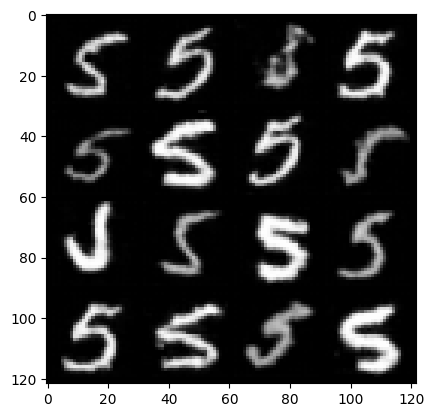

tensor(0.2875, device='cuda:0', grad_fn=<StdBackward0>)

In [ ]:
noise = gen_noise(16, noise_dim, device)
generated = gen(noise)
generated = torch.nn.functional.adaptive_avg_pool2d(generated, output_size=28)
show(generated, 16)
torch.std(generated)

In [ ]:
from torchvision.utils import save_image

for i in range(0, 10):
 noise = gen_noise(1, noise_dim, device)
 generated = gen(noise)
 generated = torch.nn.functional.adaptive_avg_pool2d(generated, output_size=28)
 name = f'{i}.png'
 save_image(generated, f'/content/drive/MyDrive/generated_mnist_aug3/{name}')